# Introduction

This notebook will introduce the "small data" problem, using standard ML tools.

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from entlearn.utils.synthetic_data import make_worm
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier
from utilities.utilities import my_pairplot

np.random.seed(42)

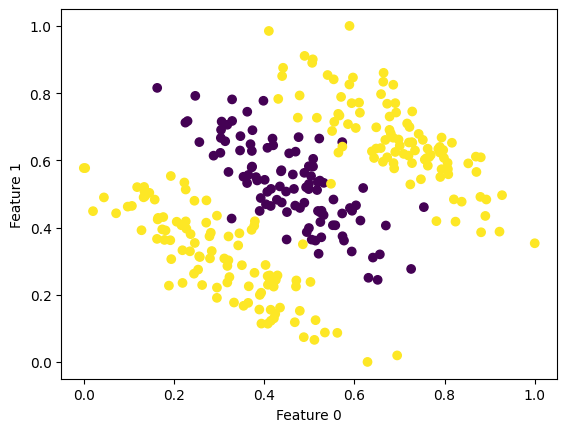

In [2]:
T = 300
D = 2

X, y = make_worm(D, T, 8)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

inner_cv = StratifiedShuffleSplit(n_splits=1, random_state=42, train_size=150)
outer_cv = StratifiedShuffleSplit(n_splits=10, train_size=200)

We can use the `my_pairplot` function to see the distribution for each class in each dimension. 

In this case, the dimensionality of the problem is 2.

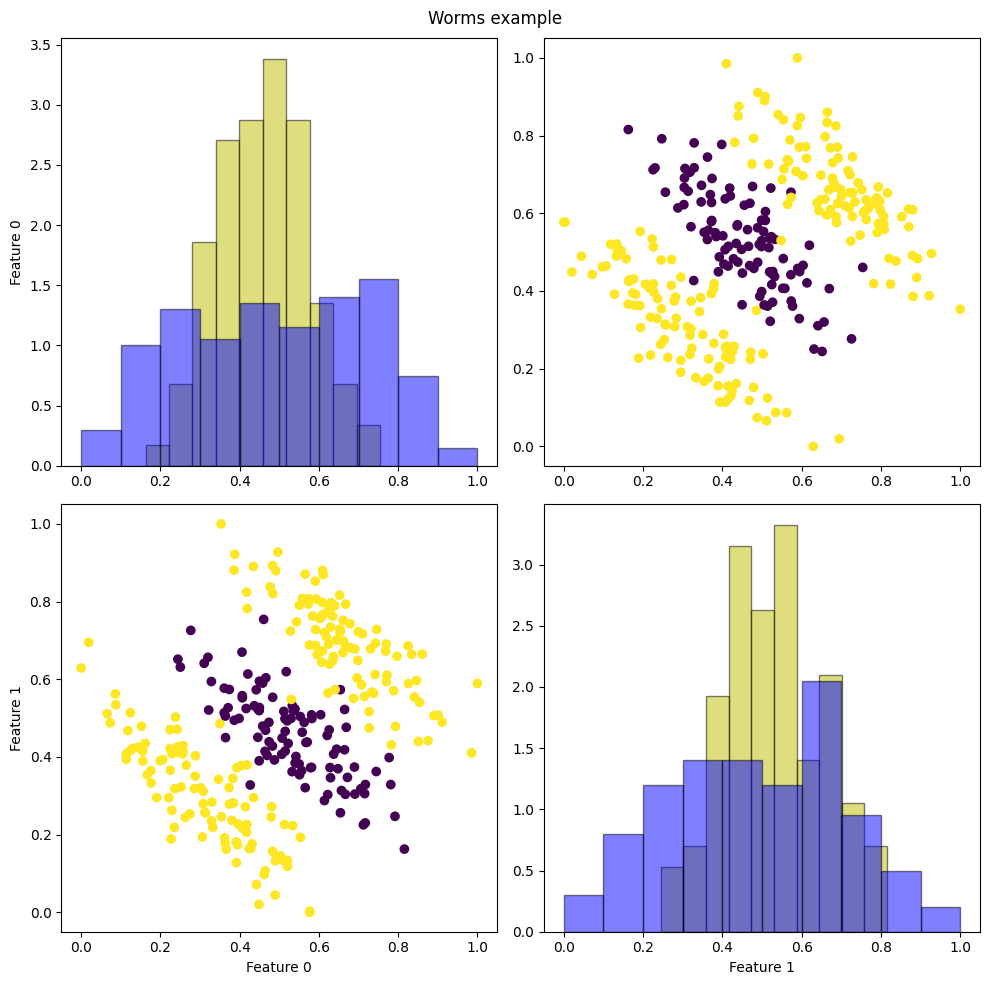

In [3]:
my_pairplot(X,y, "Worms example")

In [4]:
names = [
    "Random Forest",
    "Neural Net",
    "Gradient Boosting"
]

classifiers = [
    {
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [10, 50, 100],
            "max_depth": [5, 10, 20, None,],  
            "max_features": ["sqrt", "log2", ],
            'min_samples_split': [2, 5],
        },
    },
    {
        "estimator": MLPClassifier(
            max_iter=2000, random_state=42, early_stopping=True, n_iter_no_change=10
        ),
        "param_grid": {
            'solver': ['sgd'],
            'hidden_layer_sizes': [(50,), (100,), (150,), (250,), (50, 50, ), (100, 50, ), (150, 100, ), (250, 150, ),],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.001, 0.01, 0.1], 
        }
    },
    {
        "estimator": GradientBoostingClassifier(
            n_estimators=500,
            random_state=42,
            n_iter_no_change=10, 
            validation_fraction=0.1,
        ),
        "param_grid": {
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 8],
            'subsample': [0.7, 0.9, 1.0], 
            'max_features': ['sqrt', 'log2'],
            'min_samples_leaf': [1, 5, 10],
        },
    },
    {
        "estimator": TabPFNClassifier(),
        "param_grid": {
            "n_estimators": [4,8]
        },
    },
]

Cross-validation 1/10 for Random Forest
Random Forest - Train score 1.00, Test score: 1.00
Cross-validation 2/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.97
Cross-validation 3/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.98
Cross-validation 4/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.99
Cross-validation 5/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.97
Cross-validation 6/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.98
Cross-validation 7/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.99
Cross-validation 8/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.98
Cross-validation 9/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.98
Cross-validation 10/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.98
Cross-validation 1/10 for Neural Net
Neural Net - Train score 0.92, Test score: 0.97
Cros

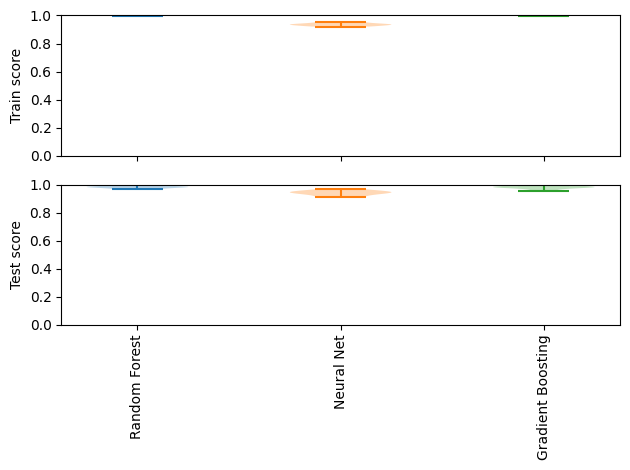

In [5]:
fig, axs = plt.subplots(2,1,sharex=True)

# For each classifier, perform cross-validation
for i, (name, clf) in enumerate(zip(names, classifiers)):

    # Initialize arrays to store scores
    test_scores = np.zeros(outer_cv.get_n_splits())
    train_scores = np.zeros(outer_cv.get_n_splits())

    # Perform crossvalidation using the split objects. It must be done manually (without cross_validate) to avoid refitting.
    for i_cv, (train_val_index, test_index) in enumerate(outer_cv.split(X, y)):

        # Separate test set from the training/validation set
        X_train_val, X_test = X[train_val_index], X[test_index]
        y_train_val, y_test = y[train_val_index], y[test_index]
        
        # Separate inner cross-validation indices
        train_index, val_index = next(inner_cv.split(X_train_val, y_train_val))
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        # Generate grid of hyperparameter combinations
        param_names, param_values = zip(*clf["param_grid"].items())
        hyperparam_combinations = [dict(zip(param_names, v)) for v in itertools.product(*param_values)]

        best_val_score = -np.inf
        best_fit_time = np.inf
        best_model = None
        for combination in hyperparam_combinations:
            est = clone(clf["estimator"])
            est.set_params(**combination)

            est.fit(X_train,y_train)

            # validation score
            val_score = roc_auc_score(y_val, est.predict_proba(X_val)[:,1])

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = est        
        
        # Compute training and test scores
        train_scores[i_cv] = roc_auc_score(y_train_val[train_index], best_model.predict_proba(X_train_val[train_index])[:,1])
        
        # Calculare roc_auc score on the test set
        best_model.predict_proba(X_test)
        test_scores[i_cv] = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

        print(f"Cross-validation {i_cv+1}/{outer_cv.get_n_splits()} for {name}")
        print(f"{name} - Train score {train_scores[i_cv]:.2f}, Test score: {test_scores[i_cv]:.2f}")
        
    # Plot the results
    axs[0].violinplot(train_scores, [i])
    axs[1].violinplot(test_scores, [i])

axs[0].set_ylabel("Train score")
axs[0].set_ylim(0, 1)
axs[1].set_ylabel("Test score")
axs[1].set_ylim(0, 1)
axs[1].set_xticks(range(len(names)), labels=names, rotation="vertical")

plt.tight_layout()
plt.show()

As it is possible to observe, all the selected methods achieve good train and test scores. We also plot the difference between training and test score, which illustrate the generalization skill of the ML methods.

## Small data

We can, however, include additional features which have no relation to the labels. This seemingly arbitrary modification is a common situation in many scientific fields, where the amount of measured features is elevated. In this case, the problem is exactly the same as before, but in order to be able to achieve good generalization the methods must be able to identify the "rule" and the dimensions in which it is applied.

Looking at the pairplot, it is easy to see that at least one of the important features must be considered.

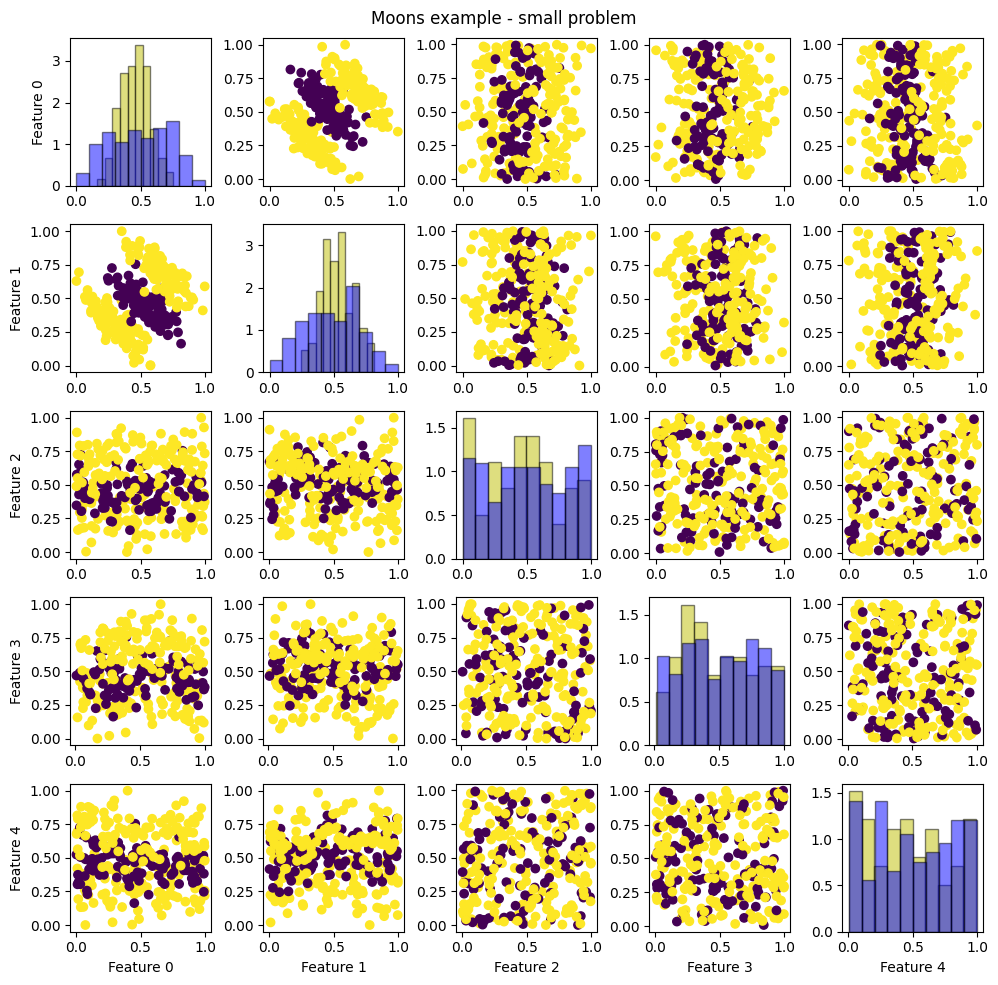

In [6]:
D = 500
X_small = np.column_stack((X, np.random.rand(T, D - 2)))
my_pairplot(X_small,y, "Moons example - small problem")

Cross-validation 1/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.46
Cross-validation 2/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.58
Cross-validation 3/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.53
Cross-validation 4/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.60
Cross-validation 5/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.57
Cross-validation 6/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.48
Cross-validation 7/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.51
Cross-validation 8/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.46
Cross-validation 9/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.59
Cross-validation 10/10 for Random Forest
Random Forest - Train score 1.00, Test score: 0.58
Cross-validation 1/10 for Neural Net
Neural Net - Train score 0.88, Test score: 0.56
Cros

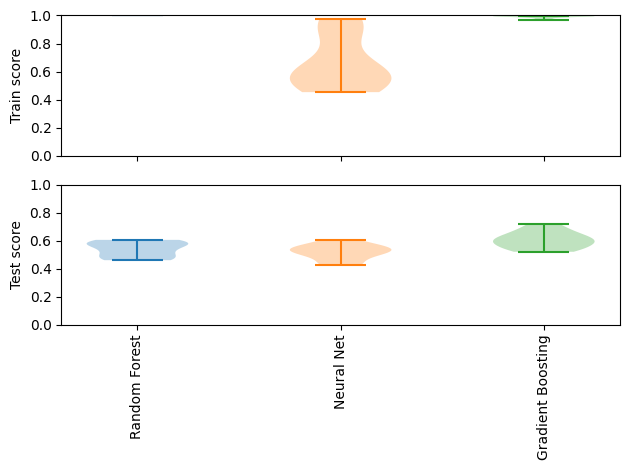

In [7]:
fig, axs = plt.subplots(2,1,sharex=True)

# For each classifier, perform cross-validation
for i, (name, clf) in enumerate(zip(names, classifiers)):

    # Initialize arrays to store scores
    test_scores = np.zeros(outer_cv.get_n_splits())
    train_scores = np.zeros(outer_cv.get_n_splits())

    # Perform crossvalidation using the split objects. It must be done manually (without cross_validate) to avoid refitting.
    for i_cv, (train_val_index, test_index) in enumerate(outer_cv.split(X_small, y)):

        # Separate test set from the training/validation set
        X_train_val, X_test = X_small[train_val_index], X_small[test_index]
        y_train_val, y_test = y[train_val_index], y[test_index]
        
        # Separate inner cross-validation indices
        train_index, val_index = next(inner_cv.split(X_train_val, y_train_val))
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        # Generate grid of hyperparameter combinations
        param_names, param_values = zip(*clf["param_grid"].items())
        hyperparam_combinations = [dict(zip(param_names, v)) for v in itertools.product(*param_values)]

        best_val_score = -np.inf
        best_fit_time = np.inf
        best_model = None
        for combination in hyperparam_combinations:
            est = clone(clf["estimator"])
            est.set_params(**combination)

            est.fit(X_train,y_train)

            # validation score
            val_score = roc_auc_score(y_val, est.predict_proba(X_val)[:,1])

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = est        
        
        # Compute training and test scores
        train_scores[i_cv] = roc_auc_score(y_train_val[train_index], best_model.predict_proba(X_train_val[train_index])[:,1])
        
        # Calculare roc_auc score on the test set
        best_model.predict_proba(X_test)
        test_scores[i_cv] = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

        print(f"Cross-validation {i_cv+1}/{outer_cv.get_n_splits()} for {name}")
        print(f"{name} - Train score {train_scores[i_cv]:.2f}, Test score: {test_scores[i_cv]:.2f}")
        
    # Plot the results
    axs[0].violinplot(train_scores, [i])
    axs[1].violinplot(test_scores, [i])

axs[0].set_ylabel("Train score")
axs[0].set_ylim(0, 1)
axs[1].set_ylabel("Test score")
axs[1].set_ylim(0, 1)
axs[1].set_xticks(range(len(names)), labels=names, rotation="vertical")

plt.tight_layout()
plt.show()

Note how the large majority of the tested methods display a drop in generalization performance, and despite achieving good results on the training data the score obtained on the test data is negatively affected.

The performance drop worsens with smaller $\frac{T}{D}$ ratios, i.e., with less data points for training or with more dimensions.